# Dive Into Boston and Seattle Airbnb Data #

## CRISP-DM Process ##

**Business Understanding**: From the datasets we can get a better knowledge how we can set the rental price for peroperties and figure out some interesting differences between Boston and Seattle Airbnb. Three business aspect questions were asked before diving into the dataset:  
1. Is there any noticeable difference between Seattle and Boston Airbnb?  
2. What are the most important features to estimate Airbnb rental price?  
3. What are the top amenities people needs most?  

**Data Understanding**:Boston dataset consists of 6036 listings while Seattle's has 8494 listings. Datasets were investigated before any preprocessing.  
**Prepare Data**: Including data cleaning, filling NAN value, one-hot encoding and MinMax preprocessing. Please refer to Preprocessing for detail.  
**Data Modeling**: Used GridSearch with 5 folds validation to find best parameter for GradientBoostingRegressor. Some other models are trained and compared as well beforehand. Please refer to Training for detail.  
**Evaluate the Results**: Result and discussion are published in https://medium.com/@shihaowen/dive-into-boston-and-seattle-airbnb-data-b4a9e79b740c. 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date
from datetime import datetime
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import MinMaxScaler
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import LogisticRegression
import sklearn.metrics
from sklearn.model_selection import GridSearchCV

listings_Boston = pd.read_csv("listings_Boston.csv")
listings_Seattle = pd.read_csv("listings_Seattle.csv")

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (87) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Preprocessing ##

In [2]:
def preprocessing(listings):
    '''
    input:
        listings: The listings dataset of target city.
    output:
        df2: The preprocessed (Cleaning, Filling Missing data, One-hot encoding, MinMax transform) listings.
        price_raw: Split from original listings and serve as target in training process.
        possible_amenities: Return all amenities listed by Airbnb host in certain city.
    '''

    # Plot the Ratio of missing data for all Column
    null_list = listings.isnull().sum()
    null_per = null_list / len(listings) * 100
    '''
    plt.figure(figsize=(15,5))
    plt.title('Distribution of the Ratio of Missing Data in Each Column')
    plt.hist(null_per, bins = np.linspace(10,100,50))
    plt.xlabel('Percentage of Missing Data')
    plt.ylabel('Count')
    plt.show()
    '''
    
    # Drop part of the columns with high ratio of missing data
    drop_index = null_per[null_per > 50].index
    listings.drop(drop_index, axis = 1, inplace = True)
    
    # Preprocess 'price' columns into numerical value
    if type(listings.price[0]) == str:
        listings.price = listings.price.apply(lambda x: float(x[1:].replace(',', '')))
    print(listings.price.describe())
    # Plot the distribution of price in Certain City
    plt.figure(figsize=(12,4))
    plt.title('Distribution of the Price')
    plt.hist(listings.price,bins = np.linspace(0,1000,100))
    plt.xlabel('Price')
    plt.ylabel('Count')
    plt.show()
    
    # Drop large price rows and some other useless columns
    drop_price_index = listings[listings.price > 500].index
    listings.drop(drop_price_index, axis = 0, inplace = True)
    listings.drop(['space', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules','listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'description', 
               'experiences_offered', 'picture_url', 'host_url', 'host_name', 'host_thumbnail_url', 'host_about', 'host_neighbourhood',
              'host_picture_url', 'host_location', 'street', 'city', 'state', 'smart_location', 'country_code', 'country', 'first_review', 'last_review', 'id', 'host_verifications', 
               'host_id', 'neighbourhood', 'calendar_last_scraped', 'market'], axis = 1, inplace = True)
    
    # Preprocess the 'host_since' column
    now = datetime.strptime('2018-09-19','%Y-%m-%d')
    listings.host_since = listings.host_since.apply(lambda x: (now - datetime.strptime(x, '%Y-%m-%d')).days)
    
    # Take care of 'amenities' column (transfer into catagorical column)
    df = listings
    amenities = df['amenities'].map(lambda d: [amenity.replace('"', "").replace("{", "").replace("}", "") for amenity in d.split(",")])
    df['amenities'] = amenities
    possible_amenities = set([item for sublist in amenities for item in sublist])
    possible_amenities = list(possible_amenities)
    del possible_amenities[1]
    print("There are {} amenities in total.".format(len(possible_amenities)))
    mlb = MultiLabelBinarizer()
    amenities_result = pd.DataFrame(mlb.fit_transform(df['amenities']),columns=mlb.classes_, index=df.index)
    df2 = pd.concat([df, amenities_result], axis=1, sort = False)
    df2.drop(['amenities'], axis = 1, inplace = True)
    
    # Preprocess some other columns, convert into numerical value
    df2['cleaning_fee'] = df2['cleaning_fee'].replace( '[$,]','', regex=True ).astype(float)
    df2['extra_people'] = df2['extra_people'].replace( '[$,]','', regex=True ).astype(float)
    df2['security_deposit'] = df2['security_deposit'].replace( '[$,]','', regex=True ).astype(float)
    df2['host_response_rate'] = df2['host_response_rate'].replace( '%','', regex=True ).astype(float)
    if type(df2.zipcode[0]) == str:
        df2.zipcode = df2.zipcode.str[:5].apply(lambda x: float(x))
    
    # Fill missing data
    df2.bathrooms.fillna(df2.groupby("bedrooms")["bathrooms"].transform("median"), inplace=True)
    df2.beds.fillna(df2.groupby("bedrooms")["beds"].transform("median"), inplace=True)
    df2.bedrooms.fillna(df2.groupby("bathrooms")["bedrooms"].transform("median"), inplace=True)
    df2.security_deposit.fillna(0, inplace = True)
    df2.cleaning_fee.fillna(0, inplace = True)
    fillmean_list = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 
                     'review_scores_location', 'review_scores_value', 'reviews_per_month']
    for col in fillmean_list:
        df2[col].fillna(df[col].mean(), inplace = True)
    df2['host_response_rate'].fillna(df2.host_response_rate.mean(), inplace = True)   
    df2.zipcode.fillna(listings_Boston.groupby('neighbourhood_cleansed')['zipcode'].apply(lambda x: x.fillna(x.value_counts().index[0])), inplace = True)
    
    # One-hot encoding the whole dataframe
    df2 = pd.get_dummies(df2)
    price_raw = df2['price']
    df2 = df2.drop('price', axis = 1)
    
    # Use MinMax to process some of the numerical data
    scaler = MinMaxScaler()
    numerical = ['host_since', 'latitude', 'longitude', 'review_scores_rating']
    df2[numerical] = scaler.fit_transform(df2[numerical])
    return df2, price_raw, possible_amenities

## Traning ##

In [3]:
def training(df2, price_raw, possible_amenities):
    '''
    input:
        df2: The preprocessed (Cleaning, Filling Missing data, One-hot encoding, MinMax transform) listings.
        price_raw: Split from original listings and serve as target in training process.
        possible_amenities: Return all amenities listed by Airbnb host in certain city.
    output:
        None
    '''
    
    
    # Split the preprocessed dataset into train/test dataset
    X_train, X_test, y_train, y_test = train_test_split(df2, price_raw, test_size = 0.2, random_state = 0)
    print("Training set has {} samples.".format(X_train.shape[0]))
    print("Testing set has {} samples.".format(X_test.shape[0]))
    
    # Grid Search to find Best Parameter
    param_grid = {'n_estimators': [400], 
                  'learning_rate': [0.05],
                  'max_depth': [10],
                  'min_samples_split': [5],
                  'subsample': [0.7]
                 }

    forest_reg = GradientBoostingRegressor(random_state = 42)
    grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring = 'neg_mean_squared_error', return_train_score=True)
    grid_search.fit(X_train, y_train)
    print(grid_search.best_params_)
    cvres = grid_search.cv_results_
    for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
        print(np.sqrt(-mean_score), params)
    y_pred = grid_search.predict(X_test)
    print("Error Score on Test Data: {}.".format(np.sqrt(sklearn.metrics.mean_squared_error(y_test, y_pred))))
    # Plot Featrue Importance
    feature_importances = grid_search.best_estimator_.feature_importances_
    features = sorted(zip(feature_importances, df2.columns), reverse=True)
    attribute = []
    coefficient = []
    for feature in features:
        attribute.append(feature[1]) 
        coefficient.append(feature[0])
    plt.figure(figsize=(12,4))
    plt.bar(attribute[:20], height=coefficient[:20])
    plt.xticks(rotation=90)
    plt.xlabel('feature')
    plt.ylabel('feature importance')
    plt.title('feature importance for the Top 20 features')
    plt.show()
    
    # Plot Amenity importance
    amenity= []
    amn_coef = []
    for feature in features:
        if feature[1] in possible_amenities:
            amenity.append(feature[1])
            amn_coef.append(feature[0])
    plt.figure(figsize=(8,4))
    plt.bar(amenity[:10], height=amn_coef[:10])
    plt.xticks(rotation = 90)
    plt.xlabel('amenity')
    plt.ylabel('amenity importance')
    plt.title('feature importance for the Top 10 amenities')
    plt.show()

count    6036.000000
mean      184.089629
std       184.401721
min         0.000000
25%        80.000000
50%       140.000000
75%       219.000000
max      3999.000000
Name: price, dtype: float64


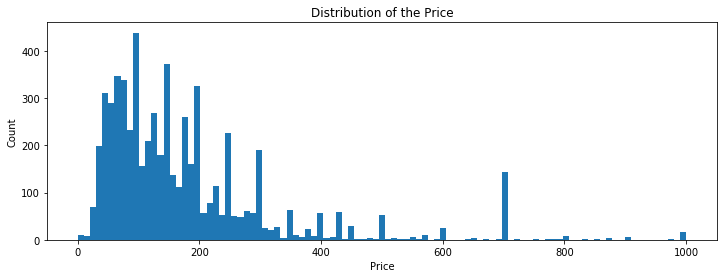

There are 120 amenities in total.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


count    8494.000000
mean      152.532494
std       137.133373
min         0.000000
25%        80.000000
50%       119.000000
75%       189.000000
max      5400.000000
Name: price, dtype: float64


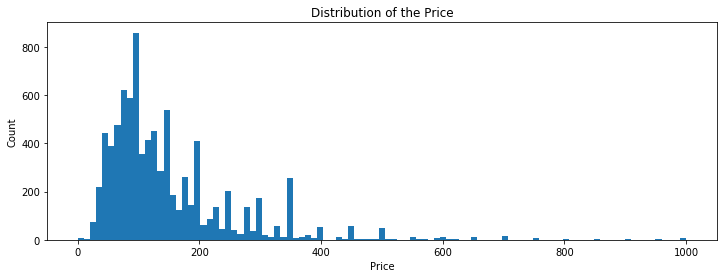

There are 168 amenities in total.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [4]:
Boston, price_Boston, possible_amenities_Boston = preprocessing(listings_Boston)
Seattle, dprice_Seattle, possible_amenities_Seattle = preprocessing(listings_Seattle)

Training set has 4611 samples.
Testing set has 1153 samples.
{'learning_rate': 0.05, 'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 400, 'subsample': 0.7}
51.425809449893165 {'learning_rate': 0.05, 'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 400, 'subsample': 0.7}
Error Score on Test Data: 48.954059956983.


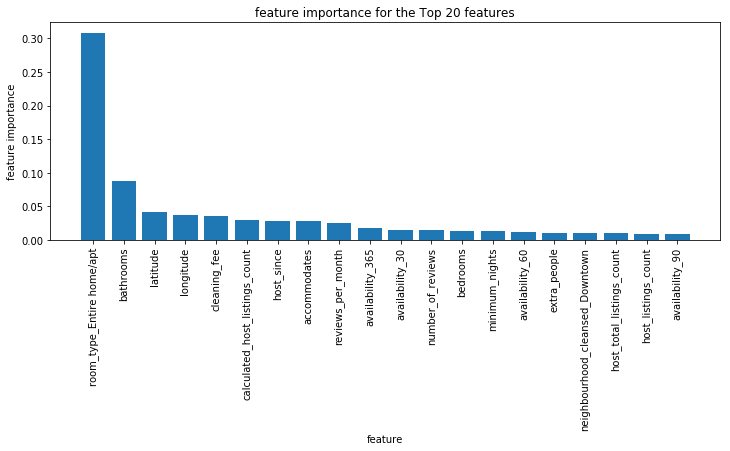

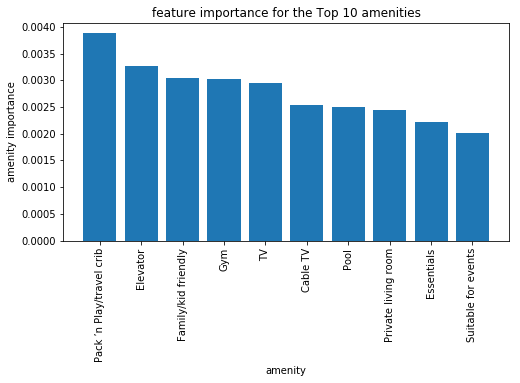

NameError: name 'price_Seattle' is not defined

In [5]:
training(Boston, price_Boston, possible_amenities_Boston)
training(Seattle, price_Seattle, possible_amenities_Seattle)